<a href="https://colab.research.google.com/github/SeongeunKim-sonja/Keras_example_study_2023/blob/main/Video/Video_Classification_with_a_CNN_RNN_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN-RNN구조를 이용한 비디오 분류 - 추가중

*이 문서는 keras 예제를 분석하여 해설을 작성한 것입니다.*

<br>[예제 페이지](https://keras.io/examples/vision/video_classification/)
<br>[딥 러닝을 이용한 자연어 처리 입문, RNN 설명명](https://wikidocs.net/22886)
<br>[LSTM, GRU 이론 및 개념 블로그](https://blog.naver.com/winddori2002/221992543837)
<br>
<br>
비디오는 순차적인 프레임들의 나열이다.<br>
각 프레임은 공간 정보를 담고 있으며, 프레임의 시퀀스에는 시간 정보를 담고 있다.<br> 이러한 관점에 주목하여, 우리는 컨볼루션(공간 처리용)과 반복레이어(시간 처리용)로 구성된 하이브리드 구조를 이용하고자 한다.<br>
좀 더 구체적으로는 CNN(Convolutional Neural Network)과 GRU레이어로 구성된 RNN(Recurrent Neural Network)를 사용한다. 이러한 종류의 하이브리드 구조를 CNN-RNN이라고 말한다. <br><br>

이 예제는 TensorFlow 2.5 이상과 TensorFlow Docs를 필요로 한다. 


#RNN 
Recurrent Neural Network

- RNN은 Sequence 데이터 처리에 강점을 가진 신경망이다.<br> 
시퀀스 데이터 : 어떠한 순서를 가진 데이터. 대표적으로 시계열/ 자연어 등이 있다.<br>  시계열은 1시, 2시, 3시 이러한 특정 시점들이 순서를 지니고, NLP의 경우 문장을 구성하는 단어들의 나열을 연결된 하나의 시퀀스로 볼 수 있다. <br> 이 뿐만 아니라 음성이나 이미지 처리를 담당하기도 한다. 

- 대표적인 순방향 신경망(Feedfoward neural network, FNN)으로 알려진 MLP와는 달리, RNN은 순환 신경망이다. 
순환 신경망이란 다음 노드로 퍼져나가며 계산되는 것이 아니라 자기자신에게 혹은 그 전 노드로 계산되는 구조이다.
RNN은 전 시점의 정보를 다음 시점으로 넘겨준다고 할 수 있다. 

*문제점 : 비교적 짧은 시퀀스에서는 좋은 성능을 보이지만, 타임스텝이 커진다면 앞쪽의 정보들이 충분히 전달되지 못한다.
또는 매 스텝마다 gradient가 전달되므로 각 스텝마다 gradient가 급격하게 증가하는 gradient exploding 이 생길 수 있다.*

<br> 

---


#LSTM
Long Short term Memory
- RNN의 단점을 보완하여 어떠한 정보를 잊을지, 유지할지 선택하여 long term과 short term에 대한 정보를 고려할 수 있다.

- Cell state + gate(Forget gate, Input gate, Output gate) 구조


---

#GRU
Gated Reccurent Unit
- 기존 LSTM 의 구조를 조금 더 간단하게 개선한 모델(gate 수가 2개)이며, LSTM과는 다르게 마지막 출력값에 활성화함수를 적용하지 않는다. 학습할 파라미터가 적기 때문에 비용이 적게 들고, 구조도 간단하지만 LSTM과 비슷한 결과를 낸다는 것이 장점이다. 


일반적으로는 LSTM 모델이 가장 많이 사용되는 것 같다. 

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


#Dataset

UCF101 데이터셋 : UCF101 - Action Recognition Data Set
<br>[데이터셋 정보](https://www.crcv.ucf.edu/data/UCF101.php)
<br>101개 동작으로 분류된 13320개의 비디오. 
<br>펀치, 자전거타기 등과 같은 동장으로 분류되어 있으며, 사람의 동작을 인식하는 모델을 생성하는 데에 사용된다. 
<br>
이 예제에서는 실행시간을 상대적으로 줄이기 위해 원본 UCF101 데이터 셋의 하위 샘플링 버전을 사용한다.

[서브샘플링 수행 방법](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)

In [2]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [3]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

#Hyperparameter

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

#Data preparation

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
484,v_TennisSwing_g09_c02.avi,TennisSwing
24,v_CricketShot_g11_c04.avi,CricketShot
315,v_Punch_g19_c03.avi,Punch
385,v_ShavingBeard_g12_c02.avi,ShavingBeard
130,v_PlayingCello_g09_c07.avi,PlayingCello
506,v_TennisSwing_g12_c03.avi,TennisSwing
399,v_ShavingBeard_g14_c04.avi,ShavingBeard
495,v_TennisSwing_g10_c06.avi,TennisSwing
393,v_ShavingBeard_g13_c04.avi,ShavingBeard
320,v_Punch_g20_c01.avi,Punch


비디오 분류모델을 구현하는 데에 있어 과제 중 하나는 비디오를 신경망에 공급하는 방법을 찾는 것이다. 
일반적으로 비디오는 순서가 있는 프레임 시퀀스 이므로 프레임을 추출하여 3D 텐서에 넣을 수 있다. 하지만 프레임 수는 비디오마다 다를 수 있으므로 패딩 같은 기법을 사용하지 않는 한 프레임을 기준으로 배치를 쌓기 힘들다.
**지정된 최대 프레임 수에 도달할 때까지 고정된 간격**으로 비디오 프레임을 저장한다. 아래에서는 다음을 수행한다.

1. 비디오 프레임 캡쳐
2. 최대 프레임 수에 도달할 때까지 프레임 추출
3. 비디오의 전체 프레임 수가 최대 프레임 수보다 작은 경우 0으로 채운다. 

OpenCV의 VideoCapture()를 사용하여 비디오로부터 프레임을 추출한다.


In [7]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

프레임으로부터 의미있는 특징을 추출해내기 위해 사전 학습된 모델을 이용한다.<br> 
keras Applications 모듈은 ImageNet-1k data set 에서 사전훈련된 여러 모델들을 제공하는데, 이 예제에서는 InceptionV3모델을 이용하기로 한다. <br><br>

Inception v3
<br>ImageNet 데이터 세트에서 정확도가 78.1% 이상인 것으로 입증된 영상 인식 모델.<br>모델 자체는 Convolution, 평균 풀링, Max pooling, 연결, Dropout, Fully connected layer를 포함한 대칭 및 비대칭 구성요소로 구성되어 있다.<br>Batch Normalization 은 모델 전반에 광범위하게 사용되며 활성화 입력에 적용<br> 
Loss Function - softmax

![U-net.png](https://cloud.google.com/static/tpu/docs/images/inceptionv3onc--oview.png?hl=ko)


In [8]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(   #keras에서 제공하는 모델 사용
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


비디오의 label은 String 형식을 띤다.<br> 
하지만 신경망은 String 값을 이해하지 못하므로, StringLookup 클래스를 사용하여 label을 정수형태로 인코딩한다.

*StringLookup - 각 data value를 indexin 해주는 함수.*

In [9]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        # 현재 비디오의 프레임으로부터 특징을 추출한다. 
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

In [11]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
11/13 [========================>.....] - ETA: 0s - loss: 1.3694 - accuracy: 0.3977
Epoch 1: val_loss improved from inf to 1.91697, saving model to /tmp/video_classifier
13/13 [==============================] - 11s 218ms/step - loss: 1.3501 - accuracy: 0.4024 - val_loss: 1.9170 - val_accuracy: 0.2793
Epoch 2/10
11/13 [========================>.....] - ETA: 0s - loss: 1.1678 - accuracy: 0.4773
Epoch 2: val_loss did not improve from 1.91697
13/13 [==============================] - 0s 15ms/step - loss: 1.1510 - accuracy: 0.4964 - val_loss: 2.0166 - val_accuracy: 0.2626
Epoch 3/10
11/13 [========================>.....] - ETA: 0s - loss: 1.0241 - accuracy: 0.5881
Epoch 3: val_loss did not improve from 1.91697
13/13 [==============================] - 0s 15ms/step - loss: 1.0208 - accuracy: 0.5880 - val_loss: 2.0053 - val_accuracy: 0.2849
Epoch 4/10
11/13 [========================>.....] - ETA: 0s - loss: 0.9231 - accuracy: 0.6278
Epoch 4: val_loss did not improve from 1.91697
13/13

Test video path: v_Punch_g07_c01.avi
1/1 [==============================] - 0s 19ms/step
  Punch: 51.75%
  CricketShot: 25.28%
  TennisSwing:  8.70%
  ShavingBeard:  7.59%
  PlayingCello:  6.67%



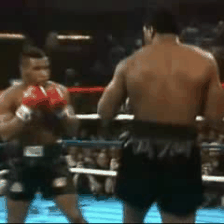

In [14]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

#확장

- 속도나 정확도를 위해 keras.applications 이 지원하는 다른 모델을 사용해볼 수도 있다. 
- 최대 시퀀스 길이 MAX_SEQ_LENGTH 값을 수정하여 성능에 어떠한 영향을 끼치는지 볼 수 있다. 
- 이와 유사한 방식으로 Transformers 기반 모델을 구현할 수 있다. 
